In [1]:
"""
Load dataset (BANKING77)
Tokenize with DistilBERT tokenizer
Define model (AutoModelForSequenceClassification)
Training with Trainer API
Evaluate (accuracy, f1)
Save results (confusion matrix, CSV)
"""

'\nLoad dataset (BANKING77)\nTokenize with DistilBERT tokenizer\nDefine model (AutoModelForSequenceClassification)\nTraining with Trainer API\nEvaluate (accuracy, f1)\nSave results (confusion matrix, CSV)\n'

In [2]:
import os
import matplotlib.pyplot as plt

# STEP X: Setup save directory
# All experiment outputs (plots, CSV, models, etc.) will be stored here.
save_dir = "09_Mini_Project/Intent_Classification/results"
os.makedirs(save_dir, exist_ok=True)   # Create folder if it does not exist

# STEP X: Save plot (e.g., confusion matrix for DistilBERT on BANKING77)
save_path = os.path.join(save_dir, "cm_distilbert_banking77.png")
plt.savefig(save_path, dpi=140)        # Save figure as PNG with good resolution
plt.show()                             # Display the plot in notebook

print("Saved confusion matrix to:", save_path)

<Figure size 640x480 with 0 Axes>

Saved confusion matrix to: 09_Mini_Project/Intent_Classification/results/cm_distilbert_banking77.png


In [3]:
#Data + Metrics

In [4]:
# STEP 1: Import required libraries
from datasets import load_dataset      # to load the BANKING77 dataset
import numpy as np                     # numerical operations
import evaluate                        # Hugging Face evaluation metrics

In [5]:
# STEP 2: Load dataset (BANKING77)
# The dataset already provides 'train' and 'test' splits
ds = load_dataset("PolyAI/banking77")

# Quick check of the splits
print(ds)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10003
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3080
    })
})


In [6]:
# STEP 3: Load evaluation metrics
acc = evaluate.load("accuracy")
f1  = evaluate.load("f1")

In [7]:
# compute_metrics => Takes the model's predictions (logits) and the ground-truth labels, 
# then returns quantitative performance metrics (Accuracy, F1) as a dictionary.

In [8]:
def compute_metrics(eval_pred):
    # Unpack predictions (logits) and true labels
    logits, labels = eval_pred
    
    # Convert logits to predicted class indices
    preds = np.argmax(logits, axis=1)

    # Compute accuracy and macro-F1 using Hugging Face evaluate
    acc_result = acc.compute(predictions=preds, references=labels)
    f1_result  = f1.compute(predictions=preds, references=labels, average="macro")

    # Return metrics as a dictionary (Trainer expects this format)
    return {
        "accuracy": acc_result["accuracy"],
        "f1_macro": f1_result["f1"],
    }

In [9]:
#DistilBERTmax_len=64

In [10]:
from transformers import AutoTokenizer

In [11]:
# STEP 4: Tokenizer setup
model_name = "distilbert-base-uncased"   # pretrained DistilBERT
num_labels = 77                          # BANKING77 has 77 intent classes
max_len    = 64                          # max sequence length

In [12]:
# Load DistilBERT tokenizer
tok = AutoTokenizer.from_pretrained(model_name)

In [13]:
# STEP 5: Tokenize the dataset
def tok_fn(batch):
    # Convert text into input IDs and attention masks
    return tok(
        batch["text"],
        truncation=True,            # cut off sequences longer than max_length
        padding="max_length",       # pad all sequences to the same length
        max_length=max_len          # maximum sequence length
    )

In [14]:
# Apply tokenizer to dataset
ds_tok = ds.map(tok_fn, batched=True)

Map:   0%|          | 0/3080 [00:00<?, ? examples/s]

In [15]:
# Rename 'label' → 'labels' (Trainer expects the column to be named 'labels')
ds_tok = ds_tok.rename_column("label", "labels")

In [16]:
# Set dataset format to PyTorch tensors
ds_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

In [17]:
#Model Training(1 epoch / batch 8)

In [18]:
from transformers import (
    AutoModelForSequenceClassification, TrainingArguments, Trainer,
    DataCollatorWithPadding
)
from transformers.trainer_utils import IntervalStrategy

In [19]:
# 1) validation split(train의 10%를 val로)
split = ds_tok["train"].train_test_split(test_size=0.1, seed=42)
train_ds = split["train"]
val_ds   = split["test"]    

In [20]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=num_labels
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# 3) Dynamic padding
collator = DataCollatorWithPadding(tokenizer=tok)

In [22]:
args = TrainingArguments(
    output_dir="./out_distilbert",      # Directory to save training outputs (checkpoints, logs, etc.)
    learning_rate=2e-5,                 # Typical learning rate for BERT models (AdamW optimizer)
    num_train_epochs=3,                 # Number of times to iterate over the entire dataset
    per_device_train_batch_size=8,      # Training batch size (smaller for MacBook M2 memory)
    per_device_eval_batch_size=16,      # Evaluation batch size (can be larger due to no backprop)
    
    eval_strategy=IntervalStrategy.EPOCH,  # Evaluate at the end of each epoch (use eval_strategy in older versions)
    save_strategy=IntervalStrategy.EPOCH,  # Save a checkpoint at the end of each epoch
    
    weight_decay=0.01,                  # AdamW weight decay for regularization (default for BERT)
    warmup_ratio=0.1,                   # Warmup for 10% of training steps before reaching full LR
    load_best_model_at_end=True,        # Load the best model at the end of training
    metric_for_best_model="f1_macro",   # Use macro-F1 as the metric to select the best model
    greater_is_better=True,             # Higher F1 score means better
    
    report_to=None,                     # Disable external loggers (e.g., W&B, TensorBoard)
    dataloader_pin_memory=False,        # Disable pin_memory for MPS (avoids warnings)
    seed=42,                            # Random seed for reproducibility
)

In [23]:
# 5) Trainer
trainer = Trainer(
    model=model,            # DistilBERT classification model we created
    args=args,              # TrainingArguments (training configuration)
    train_dataset=train_ds, # Training dataset (train split)
    eval_dataset=val_ds,    # Validation dataset (validation split)
    tokenizer=tok,          # Tokenizer (used by Trainer for batch preparation)
    data_collator=collator, # DataCollatorWithPadding (ensures dynamic padding of sequences)
    compute_metrics=compute_metrics  # Evaluation function (returns accuracy and F1)
)

/var/folders/6y/xtl4b0cx1cs9zrr9n5y814_h0000gn/T/ipykernel_12369/2516955857.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [24]:
trainer.train()             
metrics = trainer.evaluate() # validation 
print(metrics)

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,2.497300,1.529754,0.744256,0.685000
2,0.970600,0.664639,0.865135,0.850103
3,0.530700,0.518848,0.887113,0.876599


{'eval_loss': 0.5188480019569397, 'eval_accuracy': 0.8871128871128872, 'eval_f1_macro': 0.8765994412565649, 'eval_runtime': 2.2752, 'eval_samples_per_second': 439.96, 'eval_steps_per_second': 27.69, 'epoch': 3.0}


In [25]:
# 5) Quick sanity-check inference (did the model actually learn?)
from transformers import pipeline

In [26]:
# Evaluate on validation (trainer의 eval_dataset) & test
distil_val  = trainer.evaluate()                   # validation metrics
distil_test = trainer.evaluate(ds_tok["test"])     # test metrics

In [27]:
# Simple inference with the fine-tuned model
clf = pipeline(
    "text-classification",
    model=trainer.model,
    tokenizer=tok,
    return_all_scores=False   # Return only the top-1 prediction
    # Device is omitted: the model is already placed on MPS/CPU by the trainer
)

Device set to use mps:0
/Users/jessicahong/.pyenv/versions/3.11.11/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [28]:
examples = [
    "I lost my card. Can you block it?",
    "What's my current account balance?",
    "How do I change my PIN?",
]
for t in examples:
    print(t, "->", clf(t)[0])   # Prints the top-1 predicted label and its score


I lost my card. Can you block it? -> {'label': 'LABEL_13', 'score': 0.19281639158725739}
What's my current account balance? -> {'label': 'LABEL_5', 'score': 0.6128121018409729}
How do I change my PIN? -> {'label': 'LABEL_21', 'score': 0.8843547701835632}


In [29]:
# 6) Save artifacts (good for GitHub)
out_dir = "./out_distilbert"
best_dir = f"{out_dir}/best_model"
os.makedirs(out_dir, exist_ok=True)

In [30]:
print("Output directory:", out_dir)
print("Best model directory:", best_dir)
print("Contents of out_dir before saving:", os.listdir(out_dir) if os.path.exists(out_dir) else "Directory not found")

Output directory: ./out_distilbert
Best model directory: ./out_distilbert/best_model
Contents of out_dir before saving: ['metrics.json', 'checkpoint-1126', 'best_model', 'checkpoint-1251', 'checkpoint-2252', 'checkpoint-3378', 'runs']


In [31]:
# Save best model & tokenizer
trainer.model.save_pretrained(best_dir)
tok.save_pretrained(best_dir)
print("Saved model & tokenizer to:", best_dir)

Saved model & tokenizer to: ./out_distilbert/best_model


In [32]:
# Save a lightweight metrics summary (validation + test)
import json
summary = {
    "val_accuracy":  distil_val.get("eval_accuracy", None),
    "val_f1_macro":  distil_val.get("eval_f1_macro", None),
    "test_accuracy": distil_test.get("eval_accuracy", None),
    "test_f1_macro": distil_test.get("eval_f1_macro", None),
}

with open(f"{out_dir}/metrics.json", "w") as f:
    json.dump(summary, f, indent=2)

In [33]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

In [34]:
# 1) Predict on test set
trainer.model.eval()  # (optional) make sure we're in eval mode
pred_out = trainer.predict(ds_tok["test"])
y_pred = np.argmax(pred_out.predictions, axis=1)
y_true = np.array(ds_tok["test"]["labels"])

In [35]:
# 2) Confusion matrix
cm = confusion_matrix(y_true, y_pred)

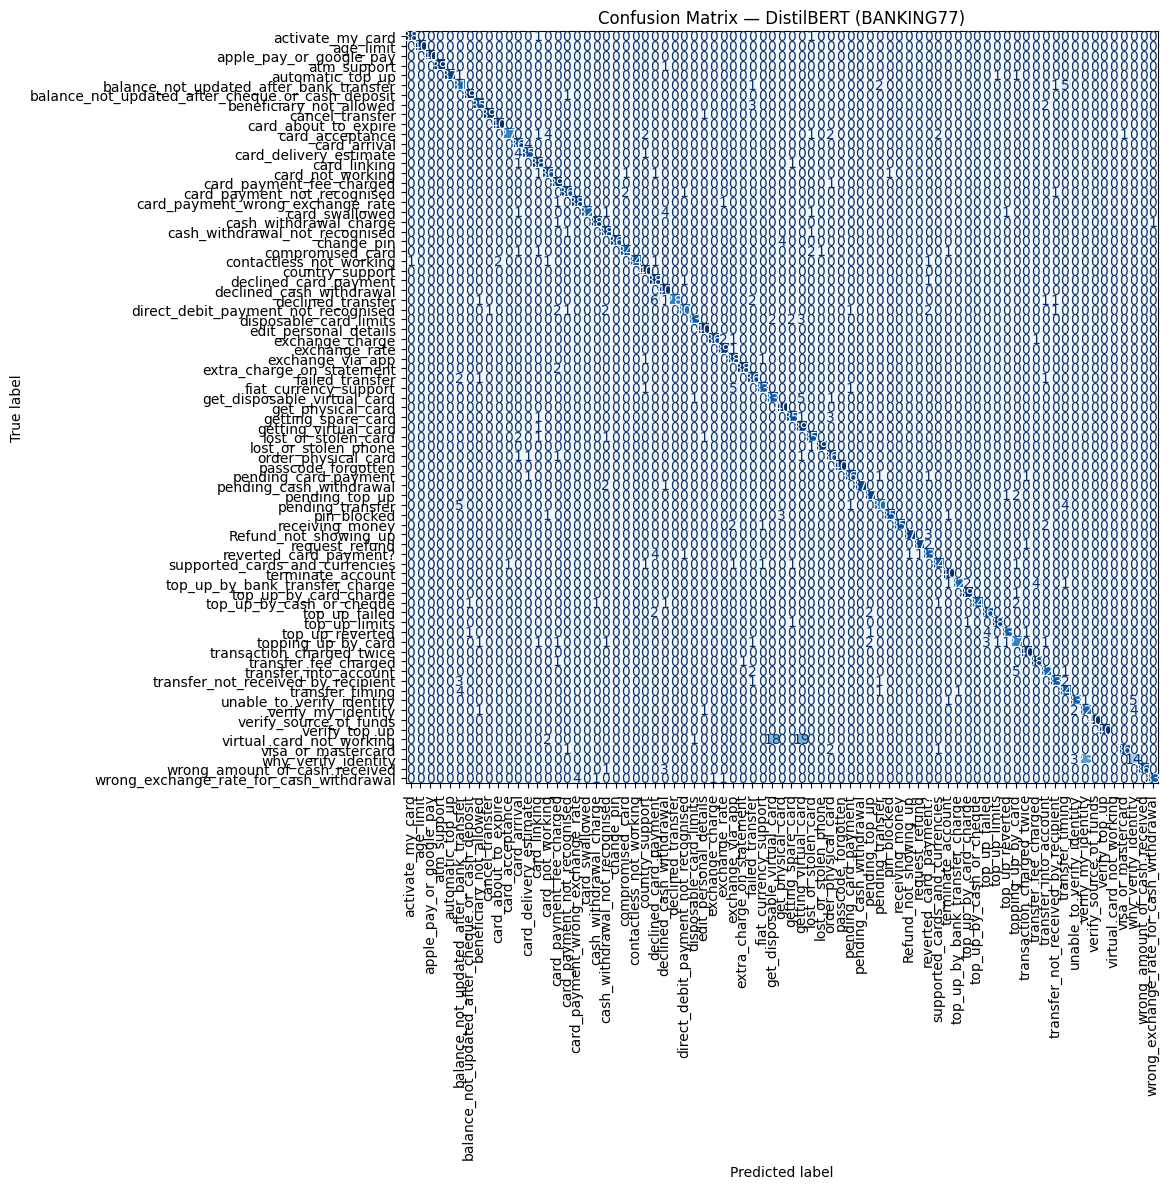

In [36]:
# 3) Pretty plot with intent names
label_names = ds["train"].features["label"].names  # human-readable labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(ax=ax, xticks_rotation=90, cmap="Blues", values_format="d", colorbar=False)
ax.set_title("Confusion Matrix — DistilBERT (BANKING77)")
plt.tight_layout()

In [37]:
# 4) Save into the project results folder
save_dir = "09_Mini_Project/Intent_Classification/results"
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "cm_distilbert_banking77.png")
plt.savefig(save_path, dpi=160)
plt.show()
print("Saved to:", save_path)

<Figure size 640x480 with 0 Axes>

Saved to: 09_Mini_Project/Intent_Classification/results/cm_distilbert_banking77.png
